# Basic Regression on Electrical Load data

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import requests
import csv
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.interpolate import interp1d
from scipy import optimize

## Load and preprocess data

### Electrical load

In [2]:
date_start = '2008-01-01'
date_end = '2019-05-18'
area = 'STH'
url_base = 'https://mimer.svk.se/'
url_target = 'ConsumptionProfile/DownloadText?groupByType=0&' + \
             'periodFrom='+date_start+'&' + \
             'periodTo='+date_end+'&' + \
             'networkAreaIdString='+area

In [3]:
url = url_base+url_target
df_load = pd.read_csv(url, sep=';', header=1, decimal=',', usecols=[0,1], names=['Datetime', 'Load'])
df_load = df_load[:-1]
df_load.index = pd.to_datetime(df_load['Datetime'])
df_load = df_load.drop(columns='Datetime')
df_load['Load'] = -df_load['Load']/10**3

### Temperature 

In [4]:
location = ('Stockholm A', 98230)
url = 'http://opendata-download-metobs.smhi.se/api/version/1.0/parameter/1/station/' + str(location[1]) + '/period/corrected-archive/data.csv'
r = requests.get(url)
decoded_content = r.content.decode('utf-8')
data = list(csv.reader(decoded_content.splitlines(), delimiter=';'))

In [5]:
header = 10
datetime = []
values = []
for d in data[header:]:
    datetime.append(d[0]+' '+d[1])
    values.append(float(d[2]))
df_temp = pd.DataFrame(data=values, index=pd.to_datetime(datetime), columns=['Temperature'])

### Concatenate and cut

In [8]:
df = pd.concat([df_load, df_temp*10], axis=1).dropna()
df = df['2010':]

### Visualize data

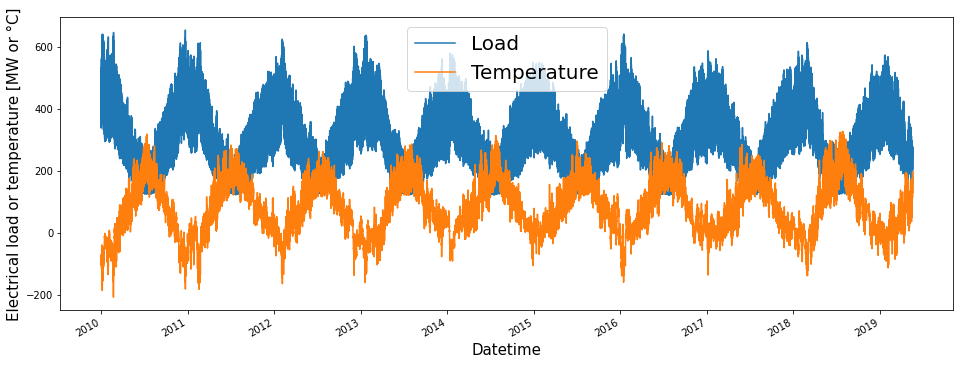

In [9]:
df.plot(figsize=(16,6))
plt.xlabel('Datetime', fontsize=15)
plt.ylabel('Electrical load or temperature [MW or °C]', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


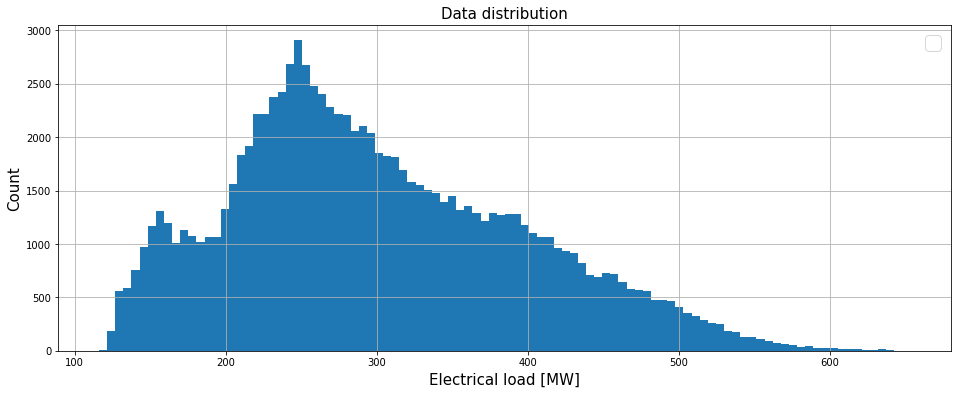

In [9]:
df['Load'].hist(bins=100, figsize=(16,6))
plt.title('Data distribution', fontsize=15)
plt.xlabel('Electrical load [MW]', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


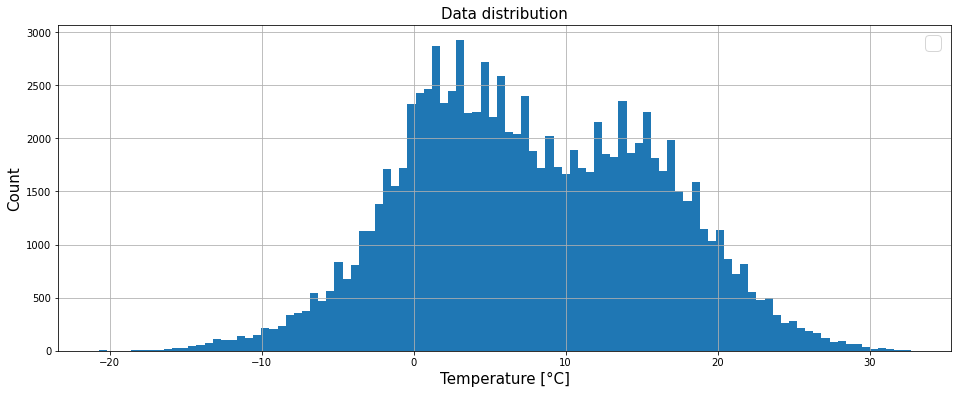

In [10]:
df['Temperature'].hist(bins=100, figsize=(16,6))
plt.title('Data distribution', fontsize=15)
plt.xlabel('Temperature [°C]', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

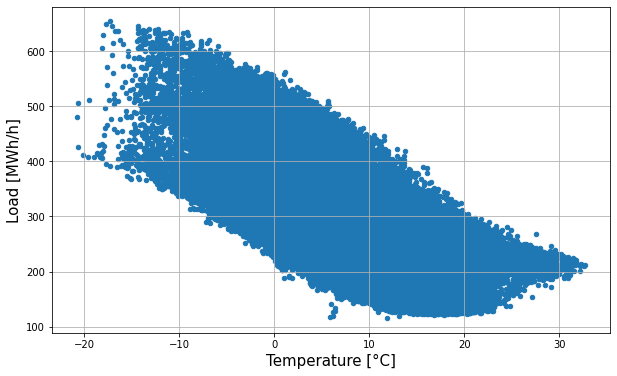

In [11]:
df.plot.scatter('Temperature', 'Load', figsize=(10,6))
plt.xlabel('Temperature [°C]', fontsize=15)
plt.ylabel('Load [MWh/h]', fontsize=15)
plt.grid()

## Scale data

In [12]:
mu_load = df['Load'].mean()
sigma_load = df['Load'].std()
y_data = (df['Load'].values-mu_load)/sigma_load

In [13]:
mu_temp = df['Temperature'].mean()
sigma_temp = df['Temperature'].std()
x_data = (df['Temperature'].values-mu_temp)/sigma_temp
x_data = x_data.reshape(-1,1)

## Create supervised problem

In [14]:
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, shuffle=True)
print('Data points in train set: {0}.'.format(len(X_train)))
print('Data points in test set: {0}.'.format(len(X_test)))
print("Shape of features in training data: {}".format(X_train.shape))
print("Shape of output in training data: {}".format(y_train.shape))
print("Shape of features in test data: {}".format(X_test.shape))
print("Shape of output in test data: {}".format(y_test.shape))

Data points in train set: 74493.
Data points in test set: 24831.
Shape of features in training data: (74493, 1)
Shape of output in training data: (74493,)
Shape of features in test data: (24831, 1)
Shape of output in test data: (24831,)


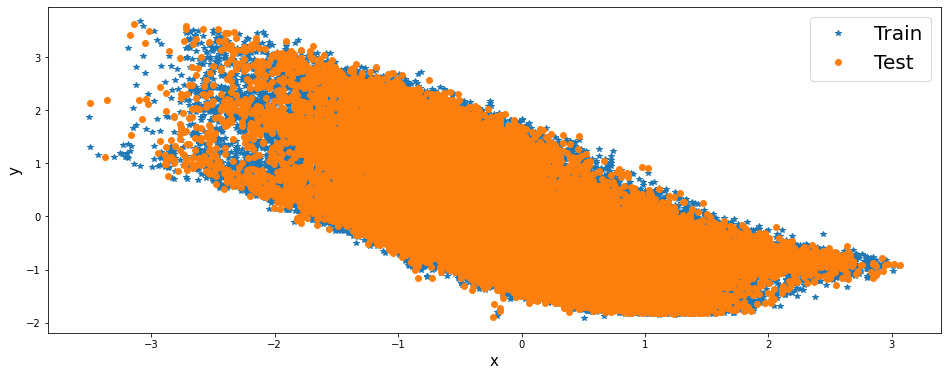

In [15]:
plt.figure(figsize=(16,6))
plt.plot(X_train, y_train, '*', label='Train')
plt.plot(X_test, y_test, 'o', label='Test')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()